# Classification Models

## Table of contents:
* [Maximum Likelihood logistic regression](#maxlike)
* [Bayesian logistic regression](#bayesian)
* [Non-linear logistic regression](#non-linear)
* [Dual logistic regression](#dual)
* [Relevance vector classification](#relevant-vector)
* [Incremental fitting and boosting](#boosting)
* [Classification trees](#trees)
* [Multi-class logistic regression](#multiclass)
* [Random trees, forests, and ferns](#forest)
* [Multi-class logistic regression](#multiclass)

# Dual logistic regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as spst
%matplotlib inline

# usual gangs

In [157]:
class DataSet:
    def __init__(self):
        pass
        
    def generate_data_set_dim2_nonlinear(self, ns):
        """
        this function generates a 2d data set of two classes which are linearly separated.

        Arguments:
            ns: number of samples

        Output:
            ds1: data on the negative side (3, ns). ds1[1] = 0 is the label.
            ds2: data on the positive side (3, ns). ds2[1] = 0 is the label.
            data  : data combined ds1 and ds2 and shuffled. (2, ns)
            label : label combined ds1 and ds2 and shuffled. (2, ns)
        """
        ns_neg = int(0.5 * ns)
        ns_pos = ns - ns_neg
        nfar_neg = int(0.99 * ns_neg)
        nbdr_neg = ns_neg - nfar_neg
        nfar_pos = int(0.99 * ns_pos)
        nbdr_pos = ns_pos - nfar_pos

        far_neg = 8 * (np.random.rand(nfar_neg) - .5) - 5
        bdr_neg = np.random.standard_t(5, size=nbdr_neg) - 0.5
        ds1x = np.hstack((far_neg, bdr_neg))
        ds1y = 10 * (np.random.rand(ns_neg) - .5)
        ds1 = np.vstack((ds1x, ds1y))

        far_pos = 8 * (np.random.rand(nfar_pos) - .5) + 5
        bdr_pos = np.random.standard_t(5, size=nbdr_pos) + 0.5
        ds2x = np.hstack((far_pos, bdr_pos))
        ds2y = 10 * (np.random.rand(ns_pos) - .5)
        ds2 = np.vstack((ds2x, ds2y))

        ang = np.pi * np.random.rand() 
        c, s = np.cos(ang), np.sin(ang)
        rot = np.array([[c, s], [-s, c]])

        ds1 = np.dot(rot, ds1)
        ds2 = np.dot(rot, ds2)

        ds1s = np.vstack((ds1, np.zeros(ns_neg)))
        ds2s = np.vstack((ds2, np.ones(ns_pos)))
        ds = np.hstack((ds1s, ds2s))
        np.random.shuffle(ds.T)

        data = ds[:2]
        label = ds[2][np.newaxis, :]

        datas, mu, sg = self.scale_coordinates(data)
        ds1s = (ds1[:2] - mu)/sg
        ds2s = (ds2[:2] - mu)/sg
        ds = {'1': ds1s, '2': ds2s}

        red = plt.scatter(ds1s[0], ds1s[1], c=(1., 0., 0.), s=3)
        blu = plt.scatter(ds2s[0], ds2s[1], c=(0., 0., 1.), s=3)
        plt.xlim((-3, 3))
        plt.ylim((-3, 3))
        plt.legend([red, blu], ["group 0", "group 1"])
        
        return ds, datas, label

    def scale_coordinates(self, x):
        mu = x.mean(keepdims=1)
        sg = x.std()
        xs = (x - mu)/sg
        return xs, mu, sg



In [221]:
class DualLogisticRegression:
    def __init__(self, x, w):
        self.D = x.shape[0]
        self.N = x.shape[1]
        self.x = x
        self.w = w
        self.psi = np.zeros((self.N, 1))
        self.sig = np.zeros((self.N, 1))
        self.cost = 0
        self.mu = np.zeros((self.N, 1))
        self.sgm = np.zeros((self.N, self.N))
        assert x.shape[1] == w.shape[1]

    def cost_function(self):
        """
        this function computes logistic cost function

        Arguments:
            psi    :  (N, 1)
            self.x :  (D, N)
        
        Intermediates:
            sig :  (N, 1)

        Output:
            L:     scalar. cost function.
        """
        L  = -np.dot(self.w, np.log(self.sig))
        L += -np.dot(1 - self.w, np.log(1 - self.sig))
        return L

    def sigmoid(self):
        """
        this function computes sigmoid function

        Arguments:
            psi    :  (N, 1)
            self.x :  (D, N)

        Intermediates:
            arg :  (1, N)
         
        Output:
            sig :  (N, 1)
        """
        arg = np.dot(np.dot(self.psi.T, self.x.T), self.x)
        arg[arg > 200] = 200
        arg[arg < -200] = -200
        sig = 1 / (1 + np.exp(-arg))
        return sig.T
    
    def set_psi_sig_cost(self, psi):
        """
        this function sets psi and update the sigmoid.

        Arguments:
            psi    :  (N, 1)
        """
        assert psi.shape[0] == self.N
        assert psi.shape[1] == 1
        self.psi = psi
        self.sig = self.sigmoid()
        self.cost = self.cost_function()

    def dL_dtheta(self):
        """
        this function generates dda/dphidalp.

        Arguments:
            self.x :  (D, N)

        Intermediate:
            sig   : (N, 1)
            pre   : (1, N)
            xx    : (N, N)

        Output:
            dLdt  : (N, 1)
        """
        err = self.sig.T - self.w
        dLdtx = -np.dot(self.x.T, err * self.x)
        dLdt = dLdtx.sum(axis=1, keepdims=1)
        return dLdt
    
    def ddL_dtheta_dtheta(self):
        """
        this function generates dda/dphidalp.

        Arguments:
            self.x :  (D, N)

        Intermediate:
            sigder : (1, N)
            sxx    : (N, N)
            xx     : (N, N)

        Output:
            dLdt  : (1, N)
        """
        sigder = self.sig.T * (1 - self.sig.T)
        xx = np.dot(self.x.T, self.x)
        sxx = np.dot(self.x.T, sigder * self.x)
        ddLdtdt = -np.dot(sxx, xx)
        return ddLdtdt

    def newton_method_update(self, psi, alpha):
        """
        this function computes sigmoid function

        Arguments:
            alpha:   scalar
            
        Intermediate:
            dLdt : (N, 1)
            hess : (N, N)

        Output:
            psi  :  (N, 1)
        """
        dLdt = self.dL_dtheta()
        hess = self.ddL_dtheta_dtheta()
        hessinv = np.linalg.inv(hess)
        psi -= alpha * np.dot(hessinv, dLdt)
        return psi

    def optimization(self, psi, alpha=0.01, nstep=1000):
        """
        this function computes sigmoid function

        Arguments:
            datab:   (D, ns)  D contains bias as well.
            label:   (1, ns)
            phi  :   (1, D)
            alpha:   scalar

        Output:
            sig  :  (ns, 1)
        """
        import copy
        dlt = 1
        step = 0
        costs = np.zeros(nstep)
        self.set_psi_sig_cost(psi)
        costs[step] = self.cost
        while dlt > 0.0001:
            step += 1
            if step == nstep:
                break
            psi = self.newton_method_update(self.psi, alpha)
            self.set_psi_sig_cost(psi)
            costs[step] = self.cost
            dlt = np.abs(costs[step] - costs[step - 1])
        self.mu = self.psi
        self.sgm = -np.linalg.inv(self.ddL_dtheta_dtheta())
        strng = '{:d} steps done: \nremaining delta = {:1.6f} \npsi = '.format(step, dlt)
        #for n in range(self.N):
        #    strng += '{:1.4f}, '.format(psi.squeeze()[n])
        print(strng)
        return self.psi
    
    def laplace_approximated_inference(self, mu, sgm):
        """
        this function computes sigmoid function

        Arguments:
            mu   : (NN, )
            sgm  : (NN, )

        Output:
            inf  : (NN, )
        """
        assert mu.shape[0] == sgm.shape[0]
        sqt = 1 + np.pi * sgm**2 / 8
        arg = -mu / np.sqrt(sqt)
        denom = 1 + np.exp(arg)
        inf = 1 / denom
        return inf
    
    def plot_decision_boundary_dim2(self):
        """
        this function computes sigmoid function

        Arguments:
            phi  : phi. (1, (K+1))
            alp  : alpha. (D, K)
            beta : scalar. learning rate.
            lmd  : scalar.

        Intermediate:
            dLdt   : ((K+1+KD), 1)
            ddLdtdt: ((K+1+KD), (K+1+KD))

        Output:
            theta: (1, (K+1+KD))
        """
        n = 201
        nn = n**2
        x = np.linspace(-3, 3, n)
        y = np.linspace(-3, 3, n)
        xg, yg = np.meshgrid(x, y)
        xss = xg.reshape(1, nn)
        yss = yg.reshape(1, nn)
        xys = np.vstack((xss, yss))
        mua = (np.dot(self.x, self.mu) * xys).sum(axis=0)
        xsgx = np.dot(np.dot(self.x, self.sgm), self.x.T)
        sgma = (np.dot(xsgx, xys) * xys).sum(axis=0)
        inf = self.laplace_approximated_inference(mua, sgma)
        inf = inf.reshape(n, n)
        inf = np.flipud(inf)
        plt.imshow(inf, extent=[-3, 3, -3, 3])
        return inf


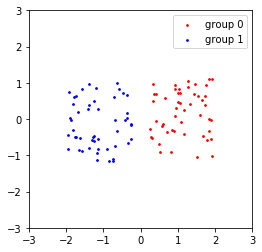

In [222]:
N = 100
plt.rcParams['figure.figsize'] = (4.0, 4.0)
ds, x, w = DataSet().generate_data_set_dim2_nonlinear(N)

328 steps done: 
remaining delta = 0.000062 
psi = 


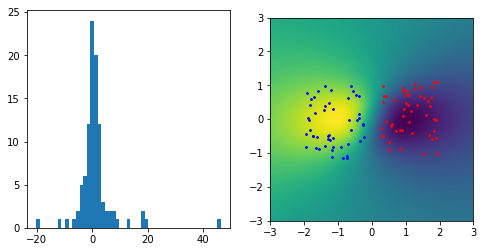

In [225]:
nstep=2000
alpha=0.0003
psi = np.random.rand(N, 1)

plt.rcParams['figure.figsize'] = (8.0, 4.0)
dlr = DualLogisticRegression(x, w)
plt.subplot(1,2,1)
psi = dlr.optimization(psi, alpha, nstep)
_ = plt.hist(psi, bins = 51)
plt.subplot(1,2,2)
inf = dlr.plot_decision_boundary_dim2()
plt.scatter(ds['1'][0], ds['1'][1], c=(1., 0., 0.), s=3)
plt.scatter(ds['2'][0], ds['2'][1], c=(0., 0., 1.), s=3)

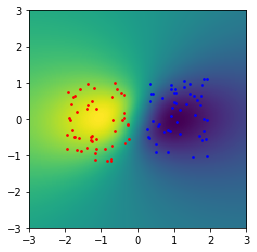

In [228]:
plt.imshow(inf, extent=[-3, 3, -3, 3])
plt.scatter(ds['1'][0], ds['1'][1], c=(0., 0., 1.), s=3)
plt.scatter(ds['2'][0], ds['2'][1], c=(1., 0., 0.), s=3)